# Anomaly detection for images
## Defect detection for quality control in manufacturing
At manufacturing sites, there are a lot of human experts who perform visual inspections.
Manufacturing companies wants to make this process to be automated somehow.

In this notebook, Convolutional AutoEncoder is applied for Anomaly detection problem.
- Classify the image to two classes; OK or NG.
- Only OK labeled data is given at train phase. (limitation)

## Dataset

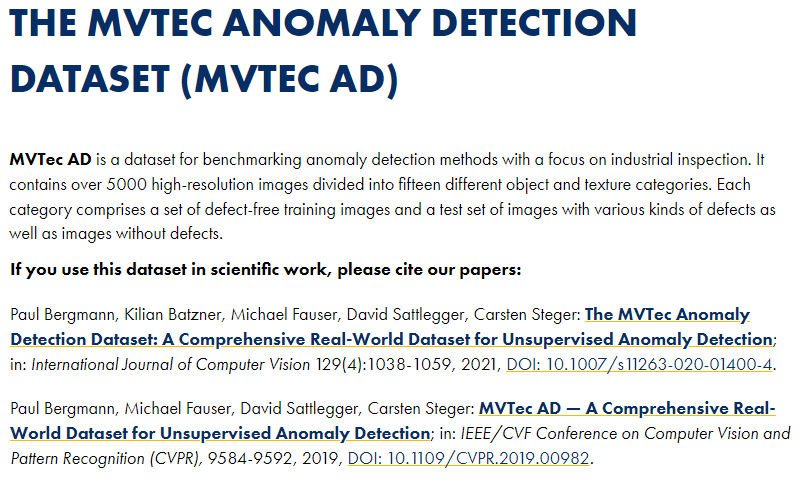

In [1]:
import argparse
import os, sys, glob
import numpy as np
import random as rn
import cv2
import matplotlib.pylab as plt
import json
import time, itertools, logging
from sklearn.svm import OneClassSVM
from sklearn import metrics, manifold, decomposition

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.compat.v1.keras.backend import set_session

### Read images 

In [2]:
def getFilePath(dir):
    pictList = []
    files = glob.glob(os.path.join(dir, '*'))

    for i in range(0, len(files)):
        if os.path.isdir(files[i]):
            pictList.extend(getFilePath(files[i]))
        else:
            if os.path.splitext(files[i])[1] in [".png"]:
                pictList.append(files[i])
    return pictList

In [3]:
def my_imread(filename, flags=cv2.IMREAD_COLOR, dtype=np.uint8):
    try:
        n = np.fromfile(filename, dtype)
        img = cv2.imdecode(n, flags)
        return img
    except Exception as e:
        print(e)
        return None

In [4]:
def prepare_data(list_of_images, img_width, img_height, img_ch):
    """
    Returns two arrays:
        x is an array of resized images
        y is an array of labels
    """

    x = [] # images as arrays

    for image in list_of_images:
        if img_ch == 1:
            im_rgb = my_imread(image, flags=cv2.IMREAD_GRAYSCALE)
            im_rgb = cv2.resize(im_rgb, (img_width,img_height), interpolation=cv2.INTER_LINEAR)
            x.append(np.reshape(im_rgb, (im_rgb.shape[0], im_rgb.shape[1] , 1)))
        else:
            im_rgb = cv2.cvtColor(my_imread(image), cv2.COLOR_BGR2RGB)
            x.append(cv2.resize(im_rgb, (img_width,img_height), interpolation=cv2.INTER_LINEAR))

    return np.array(x)

### Set environment

In [5]:
"keras version {}".format(keras.__version__)

'keras version 2.4.0'

In [6]:
"tensorflow version {}".format(tf.__version__)

'tensorflow version 2.3.0'

In [7]:
gpu_num = 0

In [8]:
if gpu_num is not None:
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1,
    gpu_options=tf.compat.v1.GPUOptions(visible_device_list="{}".format(gpu_num)))

    print("GPU used")
else:
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1, device_count={'GPU': 0})
    lprint("CPU used")

GPU used


In [9]:
sess = tf.compat.v1.Session(config=session_conf)
set_session(sess)

### Get image parh

In [10]:
TRAIN_DIR = ['bottle\\train']
TEST_DIR = ['bottle\\test']

In [11]:
train_images = []
for idx in TRAIN_DIR:
    train_images = train_images + getFilePath(idx)

test_images = []
for idx in TEST_DIR:
    test_images = test_images + getFilePath(idx)

In [12]:
train_images[:10]

['bottle\\train\\good\\000.png',
 'bottle\\train\\good\\001.png',
 'bottle\\train\\good\\002.png',
 'bottle\\train\\good\\003.png',
 'bottle\\train\\good\\004.png',
 'bottle\\train\\good\\005.png',
 'bottle\\train\\good\\006.png',
 'bottle\\train\\good\\007.png',
 'bottle\\train\\good\\008.png',
 'bottle\\train\\good\\009.png']

In [13]:
print("train_images:{} ".format(len(train_images)))
print("test_images:{} ".format(len(test_images)))

train_images:229 
test_images:63 


### Set image sizes

In [14]:
img_height = 224 
img_width = 224
img_ch = 3

### Load images

In [15]:
X_train = prepare_data(train_images, img_width, img_height, img_ch)
X_val = prepare_data(test_images, img_width, img_height, img_ch)

In [16]:
print(X_train.shape, X_val.shape)

(229, 224, 224, 3) (63, 224, 224, 3)


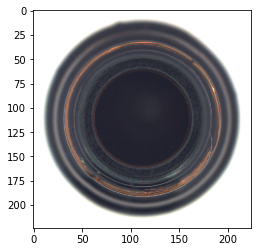

In [17]:
plt.imshow(X_train[0])
plt.show()

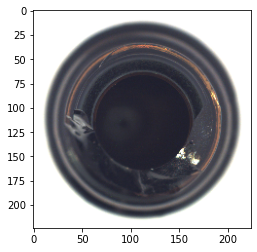

In [18]:
plt.imshow(X_val[1])
plt.show()

# EfficientNetB0

In [19]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB7

In [20]:
def effnet_based_model_B0(input_shape):
    base = EfficientNetB0(include_top=True)

    model = Model(inputs=[base.inputs], 
                  outputs=[
                           base.get_layer("block1a_se_squeeze").output, 
                           base.get_layer("block2b_se_squeeze").output, 
                           base.get_layer("block3b_se_squeeze").output,
                           base.get_layer("block4c_se_squeeze").output, 
                           base.get_layer("block5c_se_squeeze").output, 
                           base.get_layer("block6d_se_squeeze").output, 
                           base.get_layer("block7a_se_squeeze").output,
                           base.get_layer("avg_pool").output,
                           base.output
                          ]
                 )
    
    return model

In [21]:
inp_shape = (img_height, img_width, img_ch)
model = effnet_based_model_B0(inp_shape)

In [22]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

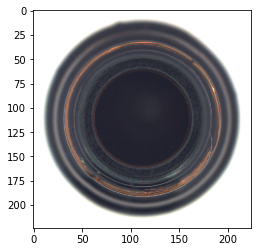

In [23]:
plt.imshow(X_train[0])
plt.show()

In [24]:
img_array = X_train[0][None, ...]
predictions = model.predict(img_array)
stacked_feature = np.hstack([predictions[0], 
                             predictions[1], 
                             predictions[2],
                             predictions[3],
                             predictions[4],
                             predictions[5],
                             predictions[6],
                             predictions[7]
                            ])

In [25]:
print(predictions[0].shape,
      predictions[1].shape,
      predictions[2].shape,
      predictions[3].shape,
      predictions[4].shape,
      predictions[5].shape,
      predictions[6].shape,
      predictions[7].shape
      )

(1, 32) (1, 144) (1, 240) (1, 480) (1, 672) (1, 1152) (1, 1152) (1, 1280)


In [26]:
predictions[0]

array([[ 0.38709396,  2.0729392 , 11.3609495 ,  1.9239035 ,  8.49416   ,
         2.1550572 ,  0.02100423, -0.1172725 ,  0.7024386 ,  9.13556   ,
         5.445534  ,  5.0462832 , 14.5883255 ,  3.9886656 ,  2.1648712 ,
         2.0089216 ,  2.083263  ,  1.8170328 ,  2.33793   ,  2.4067407 ,
         0.95195645,  1.5683799 ,  1.9490213 , -0.25673962, -0.12716404,
         2.6817465 ,  2.1577823 ,  2.5432472 , -0.27541542,  2.561271  ,
        -0.25986958,  2.5168262 ]], dtype=float32)

In [27]:
predictions[7]

array([[-0.18443033, -0.11181821,  0.30385518, ..., -0.20091876,
        -0.12172097, -0.20436658]], dtype=float32)

In [28]:
print(stacked_feature.shape)

(1, 5152)


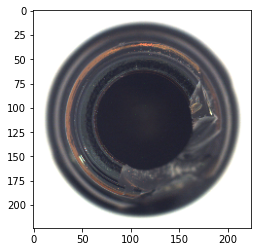

In [29]:
plt.imshow(X_val[0])
plt.show()

In [30]:
img_array = X_val[1][None, ...]
predictions = model.predict(img_array)
stacked_feature = np.hstack([predictions[0], 
                             predictions[1], 
                             predictions[2],
                             predictions[3],
                             predictions[4],
                             predictions[5],
                             predictions[6],
                             predictions[7]
                            ])

In [31]:
predictions[0]

array([[ 0.38488513,  2.0711393 , 11.354048  ,  1.9278729 ,  8.491046  ,
         2.15706   ,  0.01758424, -0.11792218,  0.6994397 ,  9.11965   ,
         5.443295  ,  5.044239  , 14.578247  ,  3.9836097 ,  2.1653678 ,
         2.0124292 ,  2.080827  ,  1.7902639 ,  2.3435037 ,  2.4018629 ,
         0.9489245 ,  1.5510563 ,  1.9512452 , -0.25677404, -0.1270829 ,
         2.6867785 ,  2.1565375 ,  2.5408247 , -0.27541542,  2.5618384 ,
        -0.25992092,  2.5147107 ]], dtype=float32)

In [32]:
predictions[7]

array([[-0.15024444,  0.12021325,  0.33525607, ..., -0.1780845 ,
         0.04654352, -0.16445708]], dtype=float32)

In [33]:
print(stacked_feature.shape)

(1, 5152)


In [34]:
ONE_FEATURE = True

In [35]:
if ONE_FEATURE:
    train_features = np.zeros((len(X_train), predictions[7].shape[1]))
else:
    train_features = np.zeros((len(X_train), stacked_feature.shape[1]))

for idx in range(len(X_train)):
    img_array = X_train[idx][None, ...]
    pred = model.predict(img_array)
    if ONE_FEATURE:
        stacked_feature = pred[7]
    else:
        stacked_feature = np.hstack([pred[0],pred[1],pred[2],pred[3],pred[4],pred[5],pred[6],pred[7]])
    train_features[idx] = stacked_feature

In [36]:
if ONE_FEATURE:
    test_features = np.zeros((len(X_val), predictions[7].shape[1]))
else:
    test_features = np.zeros((len(X_val), stacked_feature.shape[1]))

for idx in range(len(X_val)):
    img_array = X_val[idx][None, ...]
    pred = model.predict(img_array)
    if ONE_FEATURE:
        stacked_feature = pred[7]
    else:
        stacked_feature = np.hstack([pred[0],pred[1],pred[2],pred[3],pred[4],pred[5],pred[6],pred[7]])
    test_features[idx] = stacked_feature

In [37]:
print(train_features.shape, test_features.shape)

(229, 1280) (63, 1280)


In [38]:
all_features = np.vstack([train_features, test_features])

In [39]:
all_features.shape

(292, 1280)

In [40]:
labels = np.hstack([np.zeros(len(X_train)), np.ones(len(X_val))*8])

In [41]:
svm_model = OneClassSVM(kernel = 'rbf', nu = 100/292.0, gamma='auto').fit(all_features)

In [42]:
train_pred = svm_model.predict(train_features)

In [43]:
print(np.sum(train_pred > 0) / train_features.shape[0])

0.7991266375545851


In [44]:
test_pred = svm_model.predict(test_features)

In [45]:
print(np.sum(test_pred < 0) / test_features.shape[0])

0.873015873015873


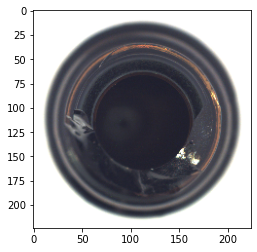

In [46]:
plt.imshow(X_val[1])
plt.show()

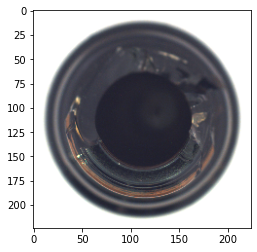

In [47]:
plt.imshow(X_val[2])
plt.show()

### Visualize the dataset using T-SNE

In [48]:
# Generate 2D embedding with TSNE
embeddings = manifold.TSNE().fit_transform(all_features)

C:\Users\umeco\anaconda3\envs\tf230gpu\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\umeco\anaconda3\envs\tf230gpu\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [49]:
embeddings.shape

(292, 2)

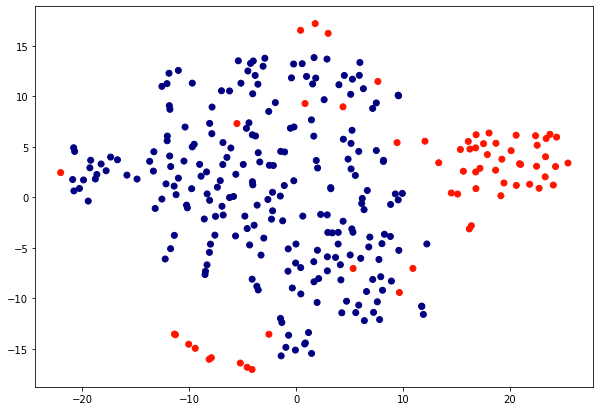

In [50]:
# Visualize TSNE embedding
vis_x = embeddings[:, 0]
vis_y = embeddings[:, 1]

plt.figure(figsize=(10,7))
plt.scatter(vis_x, vis_y, c=labels, cmap=plt.cm.get_cmap("jet", 10))
#plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)
plt.show()

# EfficientNetB7

In [51]:
def effnet_based_model_B7(input_shape):
    base = EfficientNetB7(include_top=True)

    model = Model(inputs=[base.inputs], 
                  outputs=[
                           base.get_layer("block1d_se_squeeze").output, 
                           base.get_layer("block2g_se_squeeze").output, 
                           base.get_layer("block3g_se_squeeze").output,
                           base.get_layer("block4j_se_squeeze").output, 
                           base.get_layer("block5j_se_squeeze").output, 
                           base.get_layer("block6m_se_squeeze").output, 
                           base.get_layer("block7d_se_squeeze").output,
                           base.get_layer("avg_pool").output,
                           base.output
                          ]
                 )
    
    return model

In [52]:
img_height = 600 
img_width = 600
img_ch = 3

In [53]:
X_train = prepare_data(train_images, img_width, img_height, img_ch)
X_val = prepare_data(test_images, img_width, img_height, img_ch)

In [54]:
inp_shape = (img_height, img_width, img_ch)
model = effnet_based_model_B7(inp_shape)

In [55]:
#model.summary()

In [56]:
img_array = X_train[0][None, ...]
predictions = model.predict(img_array)
stacked_feature = np.hstack([predictions[0], 
                             predictions[1], 
                             predictions[2],
                             predictions[3],
                             predictions[4],
                             predictions[5],
                             predictions[6],
                             predictions[7]
                            ])

In [57]:
ONE_FEATURE = True

In [58]:
if ONE_FEATURE:
    train_features = np.zeros((len(X_train), predictions[7].shape[1]))
else:
    train_features = np.zeros((len(X_train), stacked_feature.shape[1]))

for idx in range(len(X_train)):
    img_array = X_train[idx][None, ...]
    pred = model.predict(img_array)
    if ONE_FEATURE:
        stacked_feature = pred[7]
    else:
        stacked_feature = np.hstack([pred[0],pred[1],pred[2],pred[3],pred[4],pred[5],pred[6],pred[7]])
    train_features[idx] = stacked_feature

In [59]:
if ONE_FEATURE:
    test_features = np.zeros((len(X_val), predictions[7].shape[1]))
else:
    test_features = np.zeros((len(X_val), stacked_feature.shape[1]))

for idx in range(len(X_val)):
    img_array = X_val[idx][None, ...]
    pred = model.predict(img_array)
    if ONE_FEATURE:
        stacked_feature = pred[7]
    else:
        stacked_feature = np.hstack([pred[0],pred[1],pred[2],pred[3],pred[4],pred[5],pred[6],pred[7]])
    test_features[idx] = stacked_feature

In [60]:
print(train_features.shape, test_features.shape)

(229, 2560) (63, 2560)


In [61]:
all_features = np.vstack([train_features, test_features])
labels = np.hstack([np.zeros(len(X_train)), np.ones(len(X_val))*8])

In [62]:
svm_model = OneClassSVM(kernel = 'rbf', nu = 100/292.0, gamma='auto').fit(all_features)

In [63]:
train_pred = svm_model.predict(train_features)

In [64]:
print(np.sum(train_pred > 0) / train_features.shape[0])

0.8122270742358079


In [65]:
overkill_idx = np.where(train_pred < 0)
overkill_idx

(array([  2,   6,  15,  19,  20,  23,  28,  30,  37,  41,  43,  45,  56,
         71,  82,  84,  86,  87,  97, 101, 102, 103, 106, 109, 115, 118,
        125, 133, 141, 145, 153, 173, 175, 182, 184, 185, 186, 189, 191,
        200, 205, 210, 215], dtype=int64),)

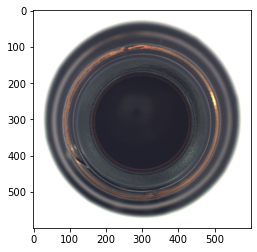

In [66]:
plt.imshow(X_train[6])
plt.show()

In [67]:
test_pred = svm_model.predict(test_features)

In [68]:
print(np.sum(test_pred < 0) / test_features.shape[0])

0.9047619047619048


In [69]:
miss_idx = np.where(test_pred > 0)
miss_idx

(array([14, 27, 29, 31, 34, 45], dtype=int64),)

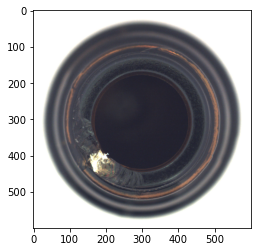

In [70]:
plt.imshow(X_val[14])
plt.show()

### Visualize the dataset using T-SNE

In [71]:
embeddings = manifold.TSNE().fit_transform(all_features)

C:\Users\umeco\anaconda3\envs\tf230gpu\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\umeco\anaconda3\envs\tf230gpu\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


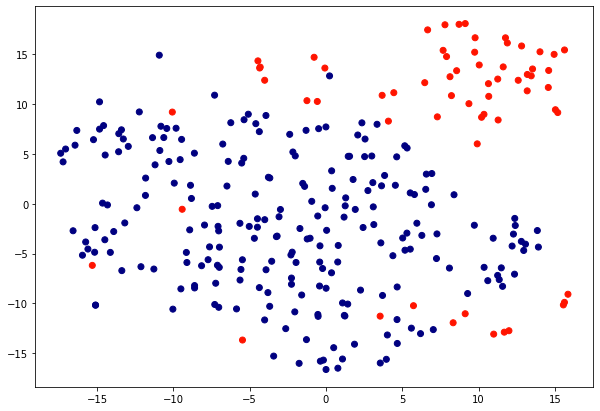

In [72]:
vis_x = embeddings[:, 0]
vis_y = embeddings[:, 1]

plt.figure(figsize=(10,7))
plt.scatter(vis_x, vis_y, c=labels, cmap=plt.cm.get_cmap("jet", 10))
#plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)
plt.show()

### use more intermediate features

In [73]:
img_array = X_train[0][None, ...]
predictions = model.predict(img_array)
stacked_feature = np.hstack([predictions[0], 
                             predictions[1], 
                             predictions[2],
                             predictions[3],
                             predictions[4],
                             predictions[5],
                             predictions[6],
                             predictions[7]
                            ])

In [74]:
ONE_FEATURE = False

In [75]:
if ONE_FEATURE:
    train_features = np.zeros((len(X_train), predictions[7].shape[1]))
else:
    train_features = np.zeros((len(X_train), stacked_feature.shape[1]))

for idx in range(len(X_train)):
    img_array = X_train[idx][None, ...]
    pred = model.predict(img_array)
    if ONE_FEATURE:
        stacked_feature = pred[7]
    else:
        stacked_feature = np.hstack([pred[0],pred[1],pred[2],pred[3],pred[4],pred[5],pred[6],pred[7]])
    train_features[idx] = stacked_feature

In [76]:
if ONE_FEATURE:
    test_features = np.zeros((len(X_val), predictions[7].shape[1]))
else:
    test_features = np.zeros((len(X_val), stacked_feature.shape[1]))

for idx in range(len(X_val)):
    img_array = X_val[idx][None, ...]
    pred = model.predict(img_array)
    if ONE_FEATURE:
        stacked_feature = pred[7]
    else:
        stacked_feature = np.hstack([pred[0],pred[1],pred[2],pred[3],pred[4],pred[5],pred[6],pred[7]])
    test_features[idx] = stacked_feature

In [77]:
print(train_features.shape, test_features.shape)

(229, 11808) (63, 11808)


In [78]:
all_features = np.vstack([train_features, test_features])
labels = np.hstack([np.zeros(len(X_train)), np.ones(len(X_val))*8])

In [79]:
svm_model = OneClassSVM(kernel = 'rbf', nu = 100/292.0, gamma='auto').fit(all_features)

In [80]:
train_pred = svm_model.predict(train_features)

In [81]:
print(np.sum(train_pred > 0) / train_features.shape[0])

0.7991266375545851


In [82]:
test_pred = svm_model.predict(test_features)

In [83]:
print(np.sum(test_pred < 0) / test_features.shape[0])

0.8571428571428571


### Future work
Try newly proposed algorithms  as quick as I can.